In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
fh = pd.read_csv('fort_hood.csv')

In [3]:
fh = fh[['query', 'page', 'clicks', 'impressions', 'ctr', 'position', 'title_tag_length', 'meta_description']]

In [4]:
fh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24539 entries, 0 to 24538
Data columns (total 8 columns):
query               24537 non-null object
page                24539 non-null object
clicks              24539 non-null object
impressions         24539 non-null object
ctr                 24539 non-null object
position            24539 non-null float64
title_tag_length    22857 non-null float64
meta_description    22857 non-null float64
dtypes: float64(3), object(5)
memory usage: 1.5+ MB


In [5]:
fh['clicks'] = fh['clicks'].replace('[,]', '', regex=True).astype('int')
fh['impressions'] = fh['impressions'].replace('[,]', '', regex=True).astype('int')
fh['ctr'] = fh['ctr'].replace('[%,]', '', regex=True).astype('float')

In [6]:
fh.dropna(inplace=True)

In [7]:
fh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22855 entries, 0 to 24538
Data columns (total 8 columns):
query               22855 non-null object
page                22855 non-null object
clicks              22855 non-null int64
impressions         22855 non-null int64
ctr                 22855 non-null float64
position            22855 non-null float64
title_tag_length    22855 non-null float64
meta_description    22855 non-null float64
dtypes: float64(4), int64(2), object(2)
memory usage: 1.6+ MB


In [8]:
# filter out row where position not between 3 and 10
fh = fh[(fh['position'] >= 3) & (fh['position'] <= 10)]

In [9]:
fh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6920 entries, 10 to 24538
Data columns (total 8 columns):
query               6920 non-null object
page                6920 non-null object
clicks              6920 non-null int64
impressions         6920 non-null int64
ctr                 6920 non-null float64
position            6920 non-null float64
title_tag_length    6920 non-null float64
meta_description    6920 non-null float64
dtypes: float64(4), int64(2), object(2)
memory usage: 486.6+ KB


### EDA

One query-page combination has nearly 200,000 impressions, with a very low, if not 0% CTR.

Text(0, 0.5, 'Impressions')

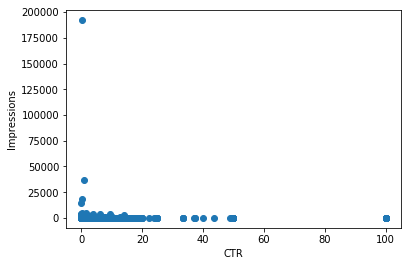

In [10]:
plt.scatter(fh['ctr'], fh['impressions'])
plt.xlabel('CTR')
plt.ylabel('Impressions')

We learn below that the outlier is the combination of the branded query and the home page. This particular query-page combination will often have a very high volume. Due to this, it is not surprising to see a low CTR. If the home page title tag and meta description show clear need for improvement, then optimizing this page would be a good use of time. Otherwise, it is probably better to focus efforts elsewhere.

In [11]:
fh[fh['impressions'] > 190000]

,query,page,clicks,impressions,ctr,position,title_tag_length,meta_description
10,fort hood,https://www.forthoodfh.com/,662,192051,0.34,9.1,44.0,268.0


Let's remove this outlier before we apply k-means to the data.

In [12]:
fh = fh[fh['impressions'] < 190000]

Text(0, 0.5, 'Impressions')

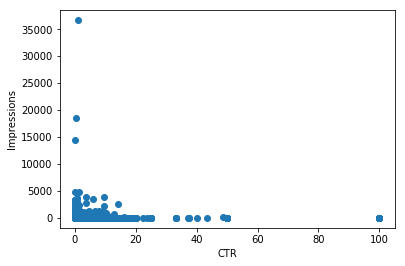

In [13]:
plt.scatter(fh['ctr'], fh['impressions'])
plt.xlabel('CTR')
plt.ylabel('Impressions')

Let's examine the three outliers in the updated plot.

In [14]:
fh[fh['impressions'] > 10000]

,query,page,clicks,impressions,ctr,position,title_tag_length,meta_description
18,fort hood housing,https://www.forthoodfh.com/fort-hood-fort-hood...,348,36659,0.95,3.5,51.0,72.0
164,ft hood,https://www.forthoodfh.com/,37,18610,0.20,9.5,44.0,268.0
4344,bonus hood,https://www.forthoodfh.com/fort-hood-fort-hood...,0,14532,0.00,3.8,67.0,69.0


- The first is a is a query that frequently pulls up the floor plans page. This page may be a good candidate for improvement.

- The second is a variation of the brand-home page combination from above, and the same logic can be applied.

- The third is an irrelevant search that brings up the floor plans page, and so can be disregarded. 

For the sake generating accurate clusters out of the remaining data points, let's also remove these three data points.

In [15]:
fh = fh[fh['impressions'] < 10000]

Text(0, 0.5, 'Impressions')

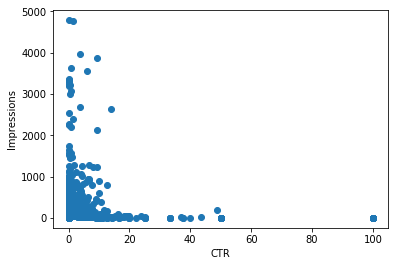

In [16]:
plt.scatter(fh['ctr'], fh['impressions'])
plt.xlabel('CTR')
plt.ylabel('Impressions')

In [17]:
from sklearn.cluster import KMeans

In [18]:
# Create a list of the 'within clusters sum of squares' for each number of clusters
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10)
    kmeans.fit(fh.drop(['query','page'], axis=1))
    wcss.append(kmeans.inertia_)

Text(0, 0.5, 'WCSS')

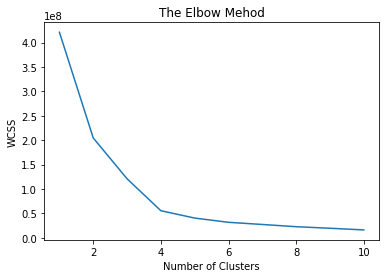

In [19]:
# Find the optimal number of clusters using the elbow method
plt.plot(range(1,11), wcss)
plt.title('The Elbow Mehod')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")

In [20]:
# Re-instantiate the kmeans object with 4 clusters
kmeans = KMeans(n_clusters=4)

In [21]:
kmeans.fit(fh.drop(['query','page'], axis=1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [22]:
kmeans.labels_

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

Text(0, 0.5, 'Impressions')

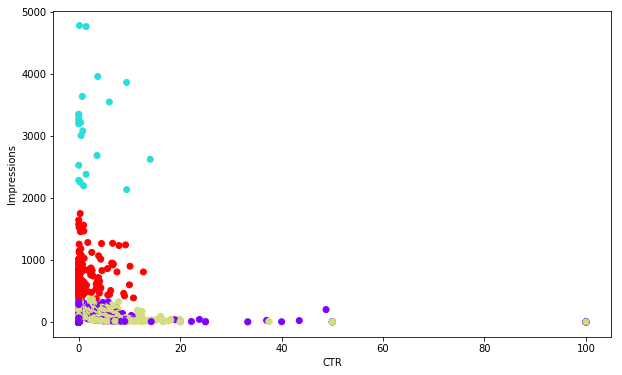

In [23]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.scatter(fh['ctr'], fh['impressions'], c=kmeans.labels_, cmap='rainbow')
ax.set_xlabel('CTR')
ax.set_ylabel('Impressions')

The cluster in the top left of the graph contains the the pages with the greatest opportunity for improvement, followed by the cluster right beneath it. The remaining two clusters are quite noisy, but they contain pages that we don't need to work on, either because there are very few impressions or the CTR is already high.

##### Final list of pages to focus on:

In [24]:
fh['cluster_label'] = kmeans.labels_

In [25]:
fh.head(10)

,query,page,clicks,impressions,ctr,position,title_tag_length,meta_description,cluster_label
15,fort hood maintenance,https://www.forthoodfh.com/fort-hood-fort-hood...,370,2625,14.10,3.2,51.0,72.0,1
16,fort hood maintenance,https://www.forthoodfh.com/resident-resources,365,3865,9.44,3.5,18.0,18.0,1
33,fort hood maintenance,https://www.forthoodfh.com/fort-hood-fort-hood...,214,3549,6.03,4.5,51.0,72.0,1
35,fort hood housing maintenance,https://www.forthoodfh.com/resident-resources,202,2135,9.46,3.1,18.0,18.0,1
42,fort hood housing office,https://www.forthoodfh.com/fort-hood-fort-hood...,149,3960,3.76,3.9,51.0,72.0,1
52,fort hood family housing maintenance,https://www.forthoodfh.com/resident-resources,115,1244,9.24,3.5,18.0,18.0,3
56,comanche 3 fort hood,https://www.forthoodfh.com/resident-resources,103,808,12.75,4.0,18.0,18.0,3
63,fhfh fort hood,https://www.forthoodfh.com/,98,201,48.76,3.0,44.0,268.0,0
64,fort hood housing villages,https://www.forthoodfh.com/fort-hood-fort-hood...,98,1234,7.94,3.1,56.0,201.0,3
65,pershing park,https://www.forthoodfh.com/fort-hood-fort-hood...,97,2686,3.61,5.7,67.0,69.0,1


 Cluster label "1" contains the pages with the most oppourtunity for growth. Cluster label "3" is the next best group. Clusters "0" and "2" can be ignored.

In [26]:
final_pages = fh[(fh['cluster_label'] == 1) | (fh['cluster_label'] == 3)]

In [27]:
final_pages.sort_values('cluster_label')

,query,page,clicks,impressions,ctr,position,title_tag_length,meta_description,cluster_label
15,fort hood maintenance,https://www.forthoodfh.com/fort-hood-fort-hood...,370,2625,14.10,3.2,51.0,72.0,1
1058,fort hood housing office,https://www.forthoodfh.com/careers/,1,3283,0.03,3.1,7.0,7.0,1
8557,fort hood,https://www.forthoodfh.com/fort-hood-fort-hood...,0,2529,0.00,7.2,69.0,71.0,1
9970,fort hood housing office,https://www.forthoodfh.com/fort-hood-fort-hood...,0,2285,0.00,3.6,50.0,182.0,1
482,fort hood housing,https://www.forthoodfh.com/fort-hood-fort-hood...,6,2257,0.27,5.3,67.0,69.0,1
448,fort hood housing office,https://www.forthoodfh.com/fort-hood-fort-hood...,7,4783,0.15,3.6,56.0,201.0,1
10354,fort hood maintenance,https://www.forthoodfh.com/Apartments/module/a...,0,3196,0.00,5.2,42.0,0.0,1
10356,fort hood maintenance,https://www.forthoodfh.com/fort-hood-fort-hood...,0,3351,0.00,5.0,56.0,201.0,1
10357,fort hood maintenance,https://www.forthoodfh.com/fort-hood-fort-hood...,0,3247,0.00,5.2,51.0,153.0,1
337,"fort hood, tx",https://www.forthoodfh.com/,12,3216,0.37,9.8,44.0,268.0,1
